# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [2]:
!conda install -c conda-forge jupyter_contrib_nbextensions

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Lynx\anaconda3

  added / updated specs:
    - jupyter_contrib_nbextensions


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py38haa244fe_0         3.1 MB  conda-forge
    jupyter_contrib_core-0.3.3 |             py_2          15 KB  conda-forge
    jupyter_contrib_nbextensions-0.5.1|     pyhd8ed1ab_2        19.5 MB  conda-forge
    jupyter_highlight_selected_word-0.2.0|py38haa244fe_1002          15 KB  conda-forge
    jupyter_latex_envs-1.4.6   |  pyhd8ed1ab_1002         735 KB  conda-forge
    jupyter_nbextensions_configurator-0.4.1|   py38haa244fe_2         491 KB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           T



==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda




# Описание данных

__Технологический процесс__
> - Rougher feed — исходное сырье
> - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
> - Xanthate \**— ксантогенат (промотер, или активатор флотации);
> - Sulphate — сульфат (на данном производстве сульфид натрия);
> - Depressant — депрессант (силикат натрия).
> - Rougher process (англ. «грубый процесс») — флотация
> - Rougher tails — отвальные хвосты
> - Float banks — флотационная установка
> - Cleaner process — очистка
> - Rougher Au — черновой концентрат золота
> - Final Au — финальный концентрат золота

__Параметры этапов__
> - air amount — объём воздуха
> - fluid levels — уровень жидкости
> - feed size — размер гранул сырья
> - feed rate — скорость подачи

__Наименование признаков__ <br><br>
_Наименование признаков должно быть такое:_ <br>
`[этап].[тип_параметра].[название_параметра]` <br>
Пример: `rougher.input.feed_ag` <br><br>
_Возможные значения для блока [этап]:_
> - rougher — флотация
> - primary_cleaner — первичная очистка
> - secondary_cleaner — вторичная очистка
> - final — финальные характеристики

_Возможные значения для блока [тип_параметра]:_
> - input — параметры сырья
> - output — параметры продукта
> - state — параметры, характеризующие текущее состояние этапа
> - calculation — расчётные характеристики

In [1]:
#  Импортируем необходимые библиотеки и зафиксируем константы и общие функции
RAND_STATE = 12345


from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import IntProgress

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


###   функция для отображения прогресса выполнения цикла

def log_progress(sequence, every=10):

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

## Откроем данные

In [2]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')

In [3]:
print('df_train:')
display(df_train.head(3))
df_train.info()
print('--------------------------------------------')
print('df_test:')
display(df_test.head(3))
df_test.info()
print('-------------------------------------------')
print('df_full:')
display(df_full.head(3))
df_full.info()

df_train:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


## Подготовка данных

### Расчитаем эффективность обогащения

Расчет будем производить на обучающей выборке для признака `rougher.output.recovery`. Расчет производится по формуле
$$Recovery = \frac{C × (F-T)}{F × (C-T)} × 100%$$
, где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [4]:
rougher_recovery = pd.DataFrame()
rougher_recovery['by_df'] = df_train['rougher.output.recovery']
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au']

rougher_recovery['counted'] = (c * (f - t)) / (f * (c - t)) * 100

Далее расчитаем MAE между нашими расчётами и значением признака. <br> 
В сырых данных присутствуют пропуски. Удалим классы с пропусками значений и посчитаем метрику

In [5]:
rougher_recovery.dropna(inplace=True)

mean_absolute_error(rougher_recovery['by_df'], rougher_recovery['counted'])

9.444891926100695e-15

__Выводы__
> MAE-метрика показала достаточно низкое значение = 9.444891926100695e-15. Из чего можно сделать предположение, что данные изначально были посчитаны достаточно точно

 ---
### Признаки, недоступные в тестовой выборке

Отобразим признаки, недоступные в тестовой выборке, но которые есть в обучающей

In [6]:
list_of_lost_columns = list(set(df_train.columns) - set(df_test.columns))
print('Признаки, отсутствующие в тестовой выборке (кол-во: ', len(list_of_lost_columns), '):', sep='')
list_of_lost_columns

Признаки, отсутствующие в тестовой выборке (кол-во: 34):


['primary_cleaner.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.calculation.au_pb_ratio',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.tail_pb',
 'secondary_cleaner.output.tail_ag',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'final.output.concentrate_ag',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_sol',
 'final.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'secondary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'rougher.output.tail_sol',
 'final.output.recovery',
 'secondary_cleaner.output.tail_sol',
 'final.output.tail_au',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.tail_ag',
 'primary_cleaner.output.tail_sol',
 'final.output.tail_sol',
 'rougher.output.tail_au',
 'final.output.concentrate_au',
 'primary_cleaner.output.concent

__Выводы__
> В тестовой выбор отсутствуют признаки с параметрами `*.output.*` — параметры продукта, `*.calculation.*` — расчётные характеристики. Также нет целевых признаков `rougher.output.recovery` и `final.output.recovery` <br>
> Скорее всего, эти признаки отсутствуют, так как замеряются и/или рассчитываются значительно позже

### Предобработка данных

В ДатаФреймах необходимо произвести следующие действия:
- привести данные к нужному типу(`date` > `to_datetime`)
- удалить признаки в обучающей выборке, которых нет в тестовой
- обработать пропуски

#### Приведение данных к нужному типу

`date` > `to_datetime`

In [7]:
def to_data_and_time(df, form='%Y%m%d %H:%M'):
    return pd.to_datetime

df_full['date'] = pd.to_datetime(df_full['date'], format='%Y%m%d %H:%M')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y%m%d %H:%M')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d %H:%M')

#### Удалим признаки в обучающей выборке, которых нет в тестовой

Перед обработкой пропусков удалим ненужные для обучения признаки

In [8]:
list_of_lost_columns.remove('rougher.output.recovery')
list_of_lost_columns.remove('final.output.recovery')
df_train = df_train.drop(list_of_lost_columns, axis=1)

#### Обработка пропусков

Пострим heatmap для отображения пропусков в данных и посчитам процент пропущенных значений

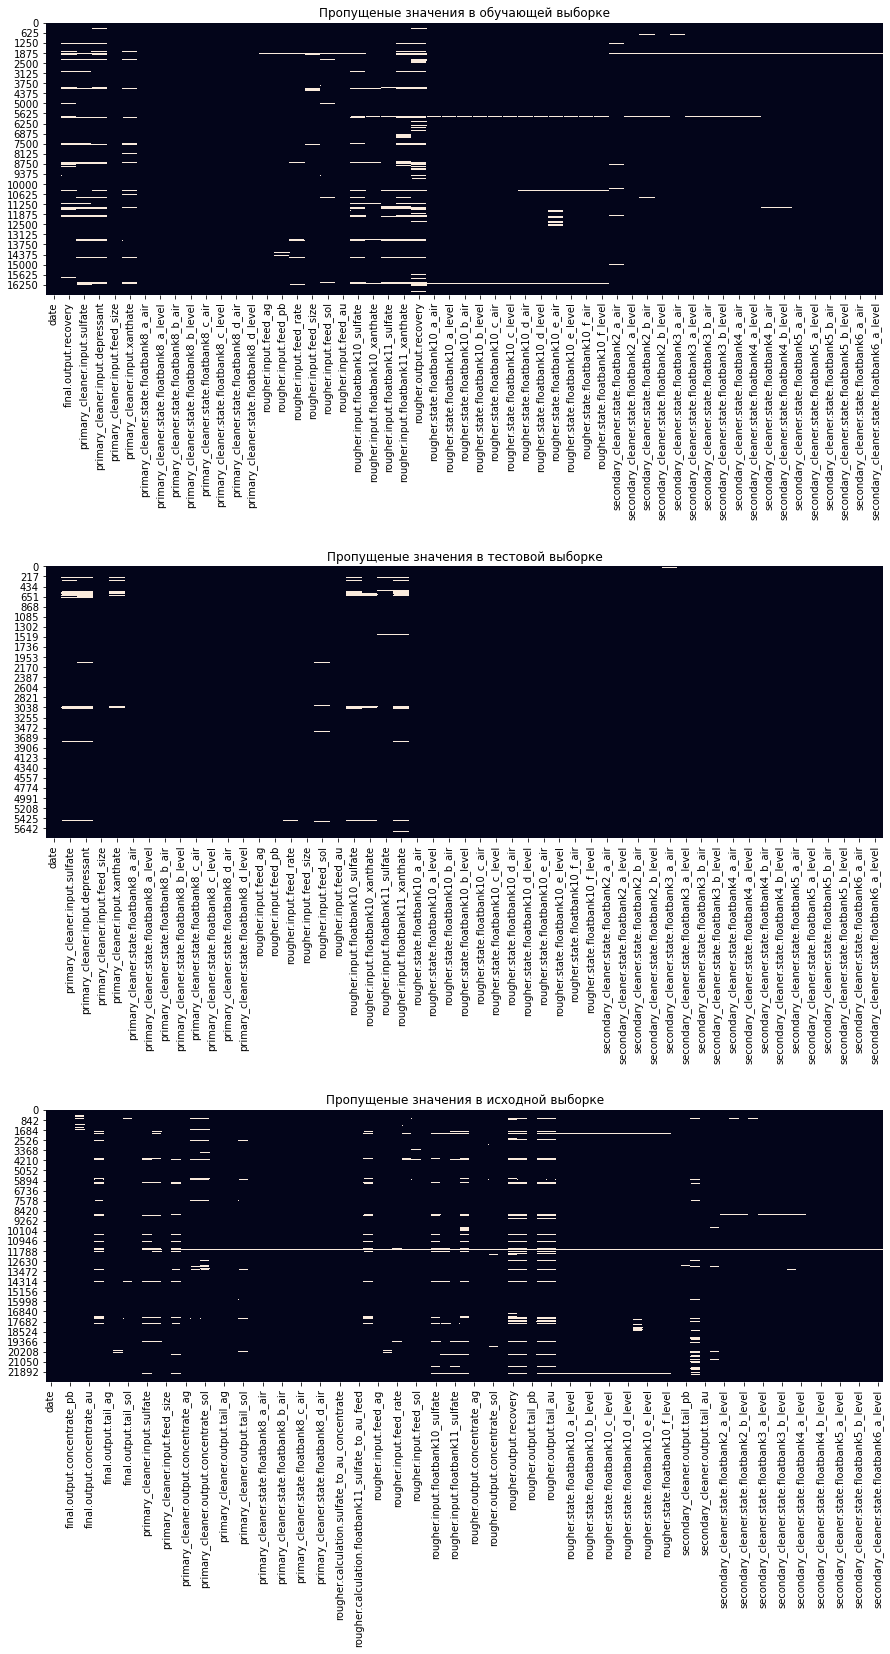

In [9]:
dfs = [[df_train, "Пропущеные значения в обучающей выборке"], 
      [df_test, "Пропущеные значения в тестовой выборке"], 
      [df_full, "Пропущеные значения в исходной выборке"]]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace=1)
i = 1
for df in dfs:
    plt.subplot(3, 1, i)
    sns.heatmap(df[0].isnull(), cbar = False).set_title(df[1])
    i+=1

Добавим целевые признаки в тестовую выборку из исходной

In [10]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                        how = 'left', 
                        left_on='date', 
                        right_on='date')
df_test.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213


Удалим классы, в которых целевые признаки пустые

In [11]:
df_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
df_test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
df_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

Посмотрим, сколько пустых значений осталось

In [12]:
print('Процент не пустых значений (тестовая выборка)', 
      round(len(df_test.dropna())/len(df_test) * 100, 1), 
      ', всего:', len(df_test))
print('Процент не пустых значений (обучающая выборка)', 
      round(len(df_train.dropna())/len(df_train) * 100, 1),
      ', всего:', len(df_train))
print('Процент не пустых значений (исходная выборка)', 
      round(len(df_full.dropna())/len(df_full) * 100, 1),
      ', всего:', len(df_full))

Процент не пустых значений (тестовая выборка) 98.8 , всего: 5290
Процент не пустых значений (обучающая выборка) 89.6 , всего: 14149
Процент не пустых значений (исходная выборка) 82.8 , всего: 19439


Считаю, что данным количеством классов в обучающей и тестовой выборках можно пожертвовать

In [13]:
df_train = df_train.dropna()
df_test = df_test.dropna()

__Выводы__ <br>
- была проведена предобработка данных
> 1. приведены данные к нужному типу(date > to_datetime)
> 2. удалены признаки в обучающей выборке, которых нет в тестовой
> 3. обработаны пропуски
- расчитана эффективность обогащения. Предоставленные данные примерно совпадают с посчитанными нами

---
## Анализ данных

In [14]:
def do_plot(data, metal=''):
    plt.figure(figsize=(17,7))
    for column in data.columns:
        sns.kdeplot(data[column],
                    shade=True)
    plt.legend(data.columns, 
               loc=u'upper center', 
               mode='expand',
               borderaxespad=0,
               ncol=4)
    plt.title(('Концентрация: '+metal))
    plt.grid(color='grey', linestyle='--', linewidth=0.2)
    plt.xlabel('Концентрация металла, %')
    plt.ylabel('Плотность')

### Изменение концентрации металлов Au, Ag, Pb на различных этапах

Для анализа возьмем исходную выборку. <br>
Выделяются следующие этапы очистки:

- концентрация металлов до какой-либо обработки: `rougher.input.feed_*`
- концентрация металлов после флотации: `rougher.output.concentrate_*`
- концентрация металлов после первого этапа очистки: `primary_cleaner.output.concentrate_*`
- концентрация металлов после второго этапа очистки: `final.output.concentrate_*`

__Для начала оценим концентрацию золота (Au) на различных этапах:__

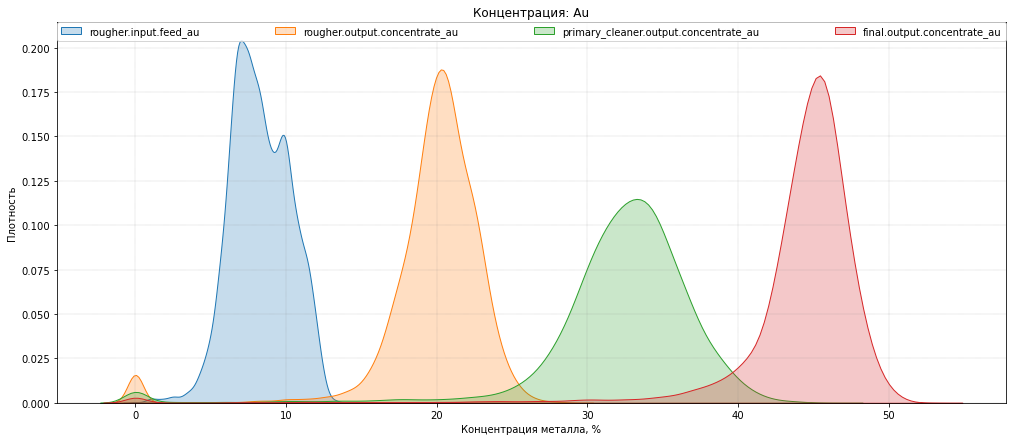

In [15]:
conc_pb = ['rougher.input.feed_au', 
           'rougher.output.concentrate_au', 
           'primary_cleaner.output.concentrate_au', 
           'final.output.concentrate_au']
do_plot(df_full[conc_pb], 'Au')

Из графика видим, что концентрация золота растет с каждым этапом обработки рудосодержащей породы <br>
Также видим небольшой пик в 0. Это значит, что присутствует материал в котором отсутствует металл

__Серебро (Ag)__

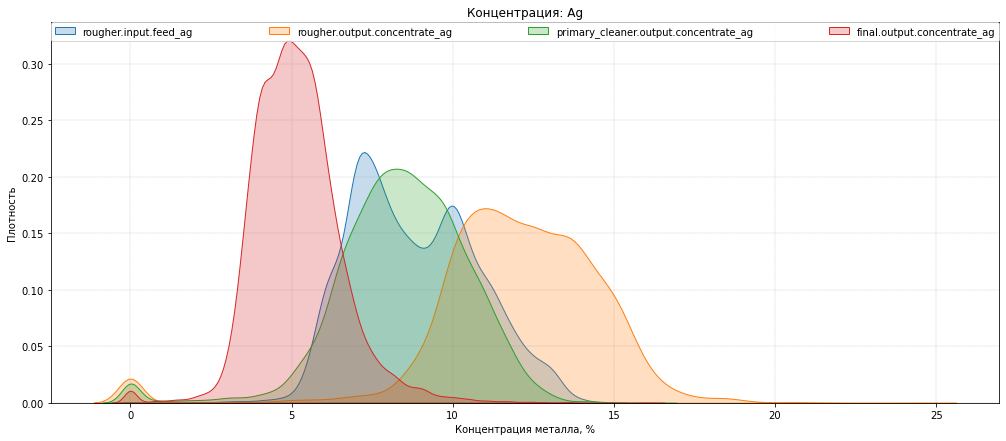

In [16]:
conc_pb = ['rougher.input.feed_ag', 
           'rougher.output.concentrate_ag', 
           'primary_cleaner.output.concentrate_ag', 
           'final.output.concentrate_ag']
do_plot(df_full[conc_pb], 'Ag')

Видим, что в процессе обработки руды концентрация серебра уменьшилась. Максимальная концентрация была после обогощения. Финальный продукт содержит меньшую концентрацию серебра, чем до обработки руды.

__Свинец (Pb)__

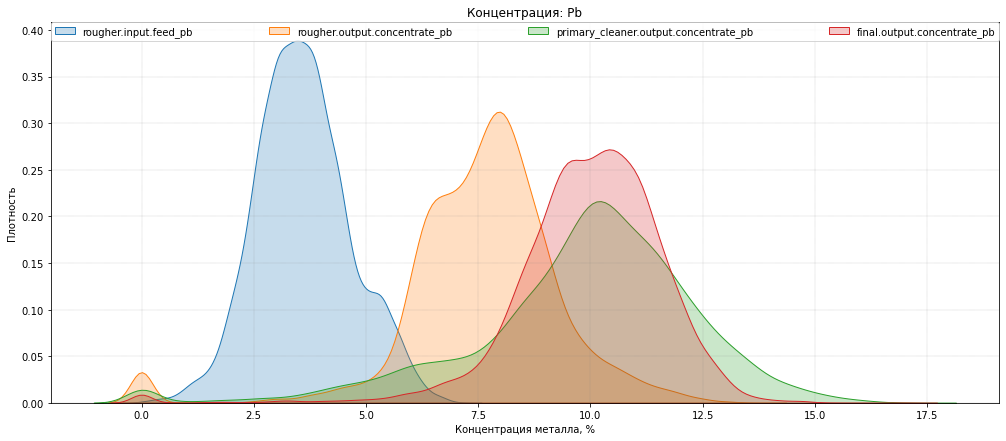

In [17]:
conc_pb = ['rougher.input.feed_pb', 
           'rougher.output.concentrate_pb', 
           'primary_cleaner.output.concentrate_pb', 
           'final.output.concentrate_pb']
do_plot(df_full[conc_pb], 'Pb')

По графикам видно, что от этапа к этапу концентрация свинца растет, кроме этапов очистки. Тут концентрация примерно одинакова, однако разброс значений в финальном продукте ниже.

### Распределения размеров гранул сырья

Данное исследование будем проводить на обучающей и тестовой выборках. <br>
За данный параметр отвечают признаки с маской `*.feed_size` <br>
Для оценки распределений предлогаю воспользоваться упрощенной техникой upsampling так как тестовая выборка значительно меньше обучающей

In [18]:
def upsample(test, repeat):
    test_upsampled = pd.concat([test] * repeat)
    return test_upsampled

Text(0, 0.5, 'Плотность')

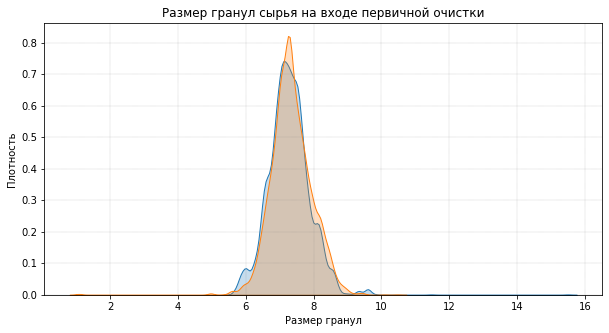

In [19]:
plt.figure(figsize=(10,5))
sns.kdeplot(upsample(df_test['primary_cleaner.input.feed_size'], 3), shade=True)
sns.kdeplot(df_train['primary_cleaner.input.feed_size'], shade=True)
plt.title('Размер гранул сырья на входе первичной очистки')
plt.grid(color='grey', linestyle='--', linewidth=0.2)
plt.xlabel('Размер гранул')
plt.ylabel('Плотность')

Text(0, 0.5, 'Плотность')

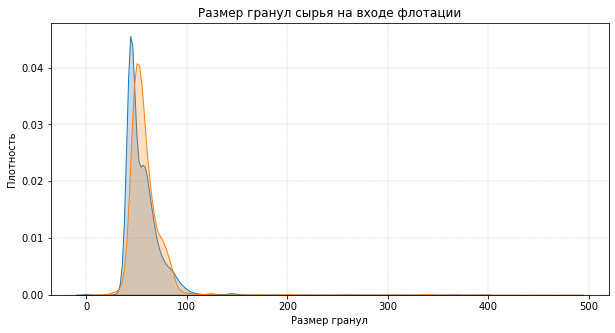

In [20]:
plt.figure(figsize=(10,5))
sns.kdeplot(upsample(df_test['rougher.input.feed_size'], 1), shade=True)
sns.kdeplot(df_train['rougher.input.feed_size'], shade=True)
plt.title('Размер гранул сырья на входе флотации')
plt.grid(color='grey', linestyle='--', linewidth=0.2)
plt.xlabel('Размер гранул')
plt.ylabel('Плотность')

Как мы видим на графиках: и в тестовой, и в обучающей выборках распределение и примерно похожи, что не дает нам оснований отвергнуть верность оценки будущей модели

### Исследуем суммарную концентрацию всех веществ на разных стадиях

Стадии для оценки:
- стадия сырья
- черновой концентрат
- финальный концентрат

Для этого построим графики размаха<br><br>
Добавим столбцы в Датафрейм для удобства удаления выбросов, где укажем суммарную концентрацию веществ на каждом этапе

Text(0.5, 0, 'Стадия')

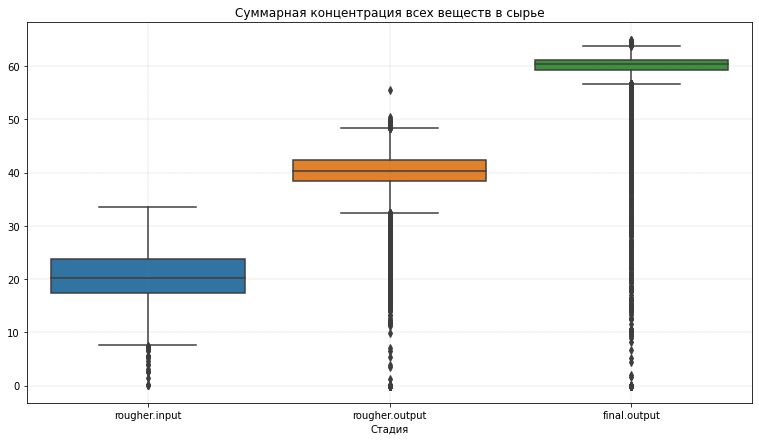

In [21]:
df_full['rougher.input'] = (df_full['rougher.input.feed_ag']+
                            df_full['rougher.input.feed_pb']+
                            df_full['rougher.input.feed_au'])
df_full['rougher.output'] = (df_full['rougher.output.concentrate_ag']+
                             df_full['rougher.output.concentrate_pb']+
                             df_full['rougher.output.concentrate_au'])
df_full['final.output'] = (df_full['final.output.concentrate_ag']+
                           df_full['final.output.concentrate_pb']+
                           df_full['final.output.concentrate_au'])
        
        
plt.figure(figsize=(13, 7))
sns.boxplot(data=df_full[['rougher.input', 'rougher.output', 'final.output']])
plt.title('Суммарная концентрация всех веществ в сырье')
plt.grid(color='grey', linestyle='--', linewidth=0.2)
plt.xlabel('Стадия')

Как мы видим из графиков размаха: на всех этапах присутствуют выбросы. Их следует удалить так как выбросы могут негативно повлиять на будущую модель

In [22]:
def drop_outliers(df, my_column):
    Q1 = df[my_column].quantile(0.25)
    Q3 = df[my_column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[my_column] >= (Q1 - 1.5*IQR)) & (df[my_column] <= (Q3 + 1.5*IQR))
    print('q1=',Q1,', q2=',Q3,'IQR=',IQR)
    return df.loc[filter]

In [23]:
print('rougher.input')
df_full = drop_outliers(df_full, 'rougher.input')
print('rougher.output')
df_full = drop_outliers(df_full, 'rougher.output')
print('final.output')
df_full = drop_outliers(df_full, 'final.output')

rougher.input
q1= 17.299415811337752 , q2= 23.817098455177366 IQR= 6.517682643839613
rougher.output
q1= 38.42910175876057 , q2= 42.381116259589106 IQR= 3.9520145008285397
final.output
q1= 59.325082875977365 , q2= 61.09111606114045 IQR= 1.7660331851630815


In [24]:
df_train = df_train[df_train['date'].isin(df_full['date'])]
df_test = df_test[df_test['date'].isin(df_full['date'])]

__Выводы__
1. Изучены изменения концентрации металлов Au, Ag, Pb на различных этапах
> - концентрация золота растет с каждым этапом обработки рудосодержащей породы
> - в процессе обработки руды концентрация серебра уменьшилась. Максимальная концентрация была после обогощения. Финальный продукт содержит наменьшую концентрацию серебра
> - от этапа к этапу концентрация свинца растет, кроме этапов очистки. Тут концентрация примерно одинакова, однако разброс значений в финальном продукте ниже.

2. Распределения размеров гранул сырья в обучающей и тестовой выборках примерно равны => нет оснований отвергнуть верность оценки будущей модели
3. Были удалены выбросы на основе суммарной концентрации веществ на различных этапах

## Модель

Функция для вычисления итоговой sMAPE - метрики <br>
Формулы:
$$sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} × 100%$$
<br>
$$Итоговое \ \  sMAPE \ = \ 25\% \ × \ sMAPE(rougher) \ + \ 75\% \ × \ sMAPE(final)$$

In [25]:
def smape(target, prediction):
    smape_value = (1 / len(target) 
                       * (abs(prediction - target) 
                       / ((abs(prediction) + abs(target)) / 2)).sum()
                   * 100)
    return smape_value
    
    
def final_smape(sMAPE_rougher, sMAPE_final):
    total_smape_value = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
    return total_smape_value

### Подготовка к обучению

Для начала стоит разделить по целевым признакам и признакам и смасштабировать выборки

In [26]:
features_train = df_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_final = df_train['final.output.recovery']
target_train_rougher = df_train['rougher.output.recovery']


features_test = df_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_final = df_test['final.output.recovery']
target_test_rougher = df_test['rougher.output.recovery']

In [27]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

### Обучение моделей

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. <br>
Для обучения воспользуемся следующими моделями:
- Линейная регрессия
- Дерево решений (макс.глубина = __[2, 20, шаг 2]__)
- Случайный лес (макс.глубина = __[2, 20, шаг 2]__, n_estimators = __[5, 30, шаг 5]__)

In [28]:
scores = pd.DataFrame(columns={'rougher', 
                               'final'})


models = [LinearRegression()]
for my_depth in range(2, 21, 2):
    models.append(DecisionTreeRegressor(max_depth=my_depth, 
                                        random_state=RAND_STATE))
    for my_est in range(5, 31, 5):
        models.append(RandomForestRegressor(max_depth=my_depth, 
                                            n_estimators=my_est,
                                            random_state=RAND_STATE))
        
scoring = make_scorer(smape, greater_is_better=False)

In [29]:
%%time

for model in log_progress(models, every=1):
    per = cross_val_score(model, 
                          features_train, 
                          target_train_rougher, 
                          cv=3,
                          scoring=scoring)
    scores.loc[str(model), 'rougher'] = per.mean().astype('float64')

    per = cross_val_score(model, 
                          features_train, 
                          target_train_final, 
                          cv=3,
                          scoring=scoring)
    scores.loc[str(model), 'final'] = per.mean().astype('float64')

scores['final_smape'] = final_smape(scores['rougher'], scores['final'])

IntProgress(value=0, max=71)

Wall time: 19min 51s


Теперь посмотрим топ-5 наиболее качественно предсказанных модели

In [30]:
scores = scores.sort_values(by='final_smape', ascending=False)
scores.head()

,rougher,final,final_smape
"RandomForestRegressor(max_depth=2, n_estimators=25, random_state=12345)",-7.31873,-8.96104,-8.55046
"RandomForestRegressor(max_depth=2, n_estimators=15, random_state=12345)",-7.33224,-8.96913,-8.55991
"RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345)",-7.34837,-8.96513,-8.56094
"RandomForestRegressor(max_depth=2, n_estimators=30, random_state=12345)",-7.25217,-9.00501,-8.5668
"RandomForestRegressor(max_depth=2, n_estimators=10, random_state=12345)",-7.41742,-9.04509,-8.63817


Таким образом, наиболее качественная модель это __Случайный лес__ с гиперпараметрами:
- макс. глубина: 2
- кол-во деверьве в лесе: 25

В таком случае качество модели, оценненое с помощью sMAPE:
> `final`   = -8.96104 <br>
> `rougher` = -7.31873 <br>
> `Итоговый sMAPE` = -8.55046

Теперь проверим выбранную модель на тостовой выборке

### Проверка модели на тестовой выборке

In [33]:
model = RandomForestRegressor(random_state=RAND_STATE, 
                              n_estimators=25, 
                              max_depth=2)

model.fit(features_train, target_train_rougher)
predictions_rougher = model.predict(features_test)

model.fit(features_train, target_train_final)
predictions_final = model.predict(features_test)

final_smape_for_test = (final_smape(smape(target_test_rougher, predictions_rougher),
                                    smape(target_test_final, predictions_final)))

print('sMAPE-итогове =', final_smape_for_test)

sMAPE-итогове = 6.953831308886764


### Проверка модели на адекватность

In [35]:
dummy_model = DummyRegressor(strategy='mean')

dummy_model.fit(features_train, target_train_rougher)
predictions_rougher_dummy = dummy_model.predict(features_test)

dummy_model.fit(features_train, target_train_final)
predictions_final_dummy = dummy_model.predict(features_test)

final_smape_for_dummy = (final_smape(smape(target_test_rougher, predictions_rougher_dummy),
                                    smape(target_test_final, predictions_final_dummy)))

print('sMAPE-итогове для dummy-модели =', final_smape_for_dummy)

sMAPE-итогове для dummy-модели = 7.094757105929864


### Итого:
sMAPE-итоговое ~ 6.95 <br>
sMAPE-итоговое для dummy-модели ~ 7.09 <br>
<br>
Можно сделать вывод, что построенная нами модель работает лучше, чем фиктивная, хоть и не на много

# Выводы
> Была построена модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Итоговая модель (Случайный лес \[макс. глубина: 2, кол-во деверьве в лесе: 25\]) имеет следующий симметричный средний процент отклонения (sMAPE) ~ 6.95 <br> <br> 
Для этого были решены следующие задачи:
>> 1. Подготолены данные к дальнейшему обучению. 
        - Проверена формула вычисления эффективности обогащения
        - Проанализированы признаки, недоступные в тестовой выборке
        - Произведена предобработка данных
>> 2. Данные проанализированы
        - Исследовано изменение концентрации элементов на каждом этапе
        - Проанализированы распределения размеров гранул на обучающей и тестовой выборках
        - Исследованы суммарные концентрации
        - Проанализированы и обработаны аномальные значения
>> 3. Построена модель прогнозирования
        - Написана функция для вычисления итогового sMAPE
        - Обучено и проверено несколько моделей
        - Выбрана лучшая модель, её качество проверено на тестовой выборке

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
    - [ ]  Проанализированы и обработаны аномальные значения
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке